<div style="width: 100%; overflow: hidden;">
    <div style="float: left"><h1 align="left"><font color='#172241'>TDX Data Science Academy Project | Real-Fake face classification</font></h1></div>
</div>

Install and load the necessary libraries.


In [1]:
!pip install keras_vggface
!pip install keras_applications
!pip install mtcnn

import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, FalseNegatives, FalsePositives, TrueNegatives, TruePositives, AUC
from tensorflow.math import confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
from tensorflow.keras.preprocessing import image_dataset_from_directory
from PIL import Image
from tqdm import tqdm
from mtcnn.mtcnn import MTCNN
from google.colab import files
from keras.preprocessing import image
from keras.engine import Model
from keras.layers import Input
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

     |████████████████████████████████| 51kB 2.9MB/s 
     |████████████████████████████████| 2.3MB 5.8MB/s 


Now that we're set with the imports, let's start by loading the data and check how many images of each type there are. Note: please specify the path to the data in case the data is not stored within google drive storage.

In [30]:
TRAINING_DIR = Path.joinpath(Path.cwd(), 'drive', 'My Drive', 'dataset-proj', 'train')
TEST_DIR = Path.joinpath(Path.cwd(), 'drive', 'My Drive', 'dataset-proj', 'validation')

print(f'Total training images REAL: {len(os.listdir(Path.joinpath(TRAINING_DIR, "real")))}')
print(f'Total training images FAKE: {len(os.listdir(Path.joinpath(TRAINING_DIR, "fake")))}\n')

print(f'Total test images REAL: {len(os.listdir(Path.joinpath(TEST_DIR, "real")))}')
print(f'Total test images FAKE: {len(os.listdir(Path.joinpath(TEST_DIR, "fake")))}')

Total training images REAL: 700
Total training images FAKE: 700

Total test images REAL: 300
Total test images FAKE: 300


There are 1400 images for the training dataset and 600 for the test set. From the cell above we can also see that we're dealing with a balanced dataset which greatly simplifies our work. Since there is no data to perform the validation on, we're going to sample 20% of the data from the training set. In the following cell we're going to feed the images through the <code>ImageDataGenerator</code> class to perform the preprocessing and data augmentation of the training, validation and test sets. This is where the validation split is done as well. The images are loaded and labeled from the subdirectories using the <code>flow_from_directory</code> method from the <code>ImageDataGenerator</code> class that belongs to the Keras API. Within the former, the <code>class_mode</code> is declared as <code>binary</code> since this is a binary classification problem. The <code>target_size</code> allows to resize the images as they're read from the disk and will also serve as the input for the first convolutional layer of our model. Finally, the <code>batch_size</code> was set to 32.




In [31]:
training_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

img_size = 300
img_batch = 32

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    subset='training',
    target_size=(img_size, img_size),
    shuffle=True,
    class_mode='binary',
    batch_size=img_batch
)

validation_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    subset='validation',
    target_size=(img_size, img_size),
    shuffle=True,
    class_mode='binary',
    batch_size=img_batch
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(img_size, img_size),
    class_mode='binary',
    batch_size=img_batch,
    shuffle=False
)

Found 1120 images belonging to 2 classes.
Found 280 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


Let's take a look at the training set and see some real and fake faces.

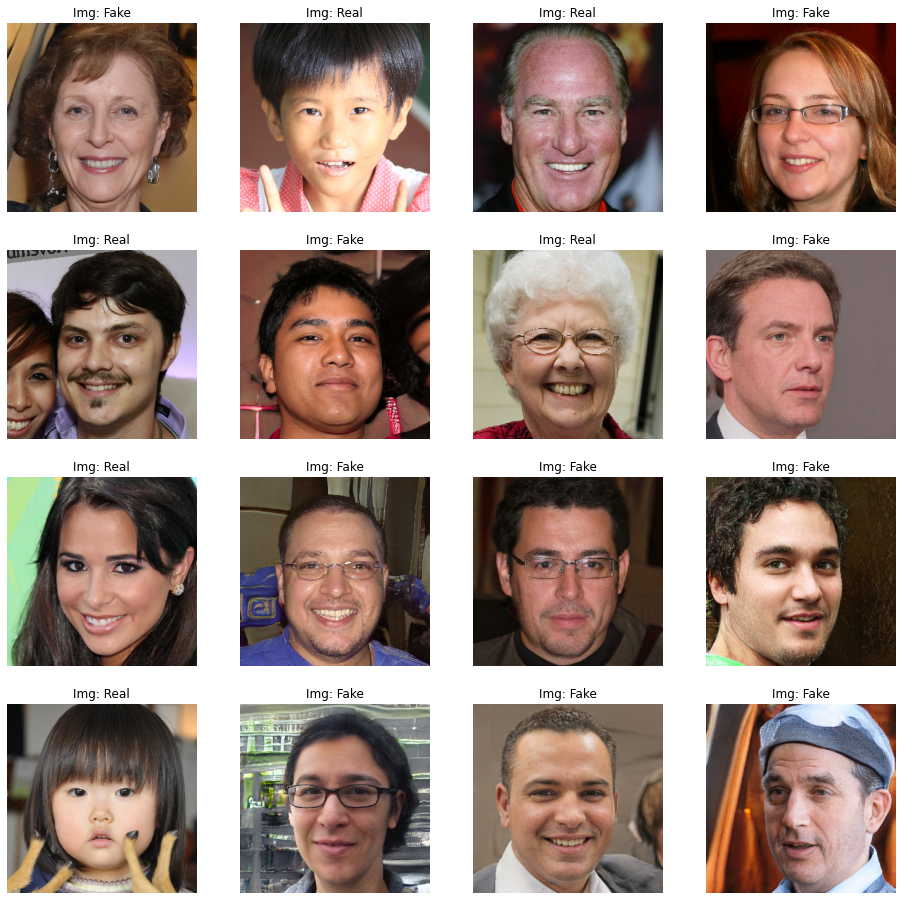

In [32]:
labels = {1.0: 'Real', 0.0: 'Fake'}

for images, images_labels in train_generator:
    plt.figure(figsize=(16, 16))
    
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.title(f'Img: {labels[images_labels[i]]}')
        plt.imshow(np.uint8(255 * images[i]))
        plt.axis('off')
    break

Let's define the model, compile it and then fit it to the training data. Since this is a binary classification problem and given our labels were also declared as binary, the loss function is going to be <code>binary_crossentropy</code>. In addition, the last dense layer has a single neuron with a sigmoid activation function, therefore, yielding a value between 0 and 1 - close to zero if the face is fake and, conversely, close to 1 if the face is deemed as real. The final value encodes the probability that the current image is class 1 (as opposed to class 0). Two callback functions were defined: <code>EarlyStopping</code> and <code>ModelCheckpoint</code>. <code>ModelCheckpoint</code> will save the best model as the <code>.fit</code> is running. The criterion chosen will save the model as long as the <code>val_loss</code> keeps decreasing. The <code>EarlyStopping</code> will stop the fitting when the <code>val_loss</code> stops decreasing.

In [32]:
model = Sequential([

    Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Flatten the results to feed into a DNN
    Flatten(),

    # 384 neuron hidden layer
    Dense(384, activation='relu'),

    # Only 1 output neuron. It will contain a value from 0-1 where 0 identifies a fake face and 1 a real face
    Dense(1, activation='sigmoid')

])

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

callback = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='model.hdf5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    train_generator,
    epochs=50,
    steps_per_epoch=25,
    validation_data=validation_generator,
    verbose=1,
    callbacks=callback
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 33, 33, 64)       

Let's plot the learning curves for both training and validation accuracy and loss.

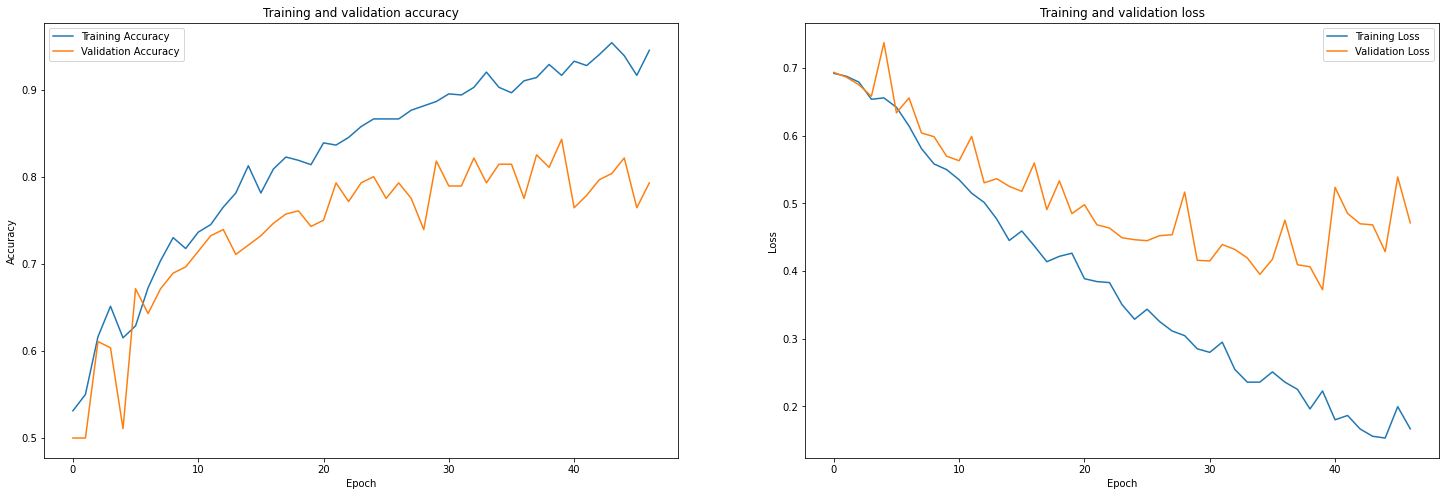

In [33]:
plt.figure(figsize=(25, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [35]:
metrics = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
index_model_checkpoint = np.argmin(history.history['val_loss'])
[f'Best {metric}: {history.history[metric][index_model_checkpoint]:.2f}' for metric in metrics]

['Best accuracy: 0.92',
 'Best val_accuracy: 0.84',
 'Best loss: 0.22',
 'Best val_loss: 0.37']

We can see that around epoch #40, which was where the best model was found, overfitting started to take place. Several efforts were made to improve the current result although none of them managed to increase the best result with the network architecture that is presented here. Tested methods: 

*   Changes to the neural network architecture, i.e., more/less convolution layers, number of filters, stride and max pooling dimensions, number of hidden layers, number of neurons in the hidden layers;
*   Different optimizer functions and learning rates;
*   Different dropout values;
*   More image augmentation to what was done, i.e., adding shear, zoom, shifts, rotations, brightness adjustments did not improve the model's performance;
*   Regularization with several reg. factors was also performed in the different layers;
*   Batch size as 32 was found to be the best value (which also has a regularization effect);
*   Image size as 300 by 300 pixels was also the optimum value according to the tests that were made.



Now, let's evaluate the model's performance on the test set. We'll start by loading the best model that was saved while running the <code>.fit</code> method.

In [33]:
def load_and_test_model(model_name, test_set, display_model_summary=False):
    try:
        loaded_model = tf.keras.models.load_model(f'{model_name}.hdf5')
    except OSError:
        print('The model called does not exist. Testing for the last saved model.')
        loaded_model = tf.keras.models.load_model('model.hdf5')
    if display_model_summary:
        loaded_model.summary()
    test_loss, test_acc = loaded_model.evaluate(test_set)
    print(f'Test loss: {round(test_loss, 2)}, Test accuracy: {round(test_acc * 100, 2)}')

In [34]:
load_and_test_model('CNN_Base_8429', test_generator)

19/19 [==============================] - 23s 1s/step - loss: 0.4175 - accuracy: 0.8183
Test loss: 0.42, Test accuracy: 81.83


The obtained test performance was approximately 82%. Now let's dive deeper and calculate more performance metrics. We'll start by defining a function to calculate every metric with a model and test dataset as inputs.

In [35]:
def calculate_model_performance_metrics(model_name, test_dataset, transfer_ml=False, model_version=0,
                                        show_plots=False):
    
    try:
        loaded_model = tf.keras.models.load_model(f'{model_name}.hdf5')
        print(f'Calculating performance metrics for model {model_name}')
    except OSError:
        print('The model called does not exist. Testing for the last saved model.')
        loaded_model = tf.keras.models.load_model('model.hdf5')

    if transfer_ml and model_version != 0:
        test_images, true_labels = test_dataset.as_numpy_iterator().next()
        test_images = utils.preprocess_input(test_images, version=model_version)
        predictions_sigmoid = loaded_model.predict(test_images, verbose=1)
    else:
        true_labels = test_dataset.labels
        predictions_sigmoid = loaded_model.predict(test_dataset, verbose=1)
    
    false_positives_negatives = []
    lower_bound_threshold = 0.2
    upper_bound_threshold = 0.7
    step = 0.001

    sigmoid_threshold = np.arange(lower_bound_threshold, upper_bound_threshold, step)

    for threshold in sigmoid_threshold:
        predictions_binary = tf.where(predictions_sigmoid > threshold, 1, 0)
        conf_matrix = confusion_matrix(true_labels, predictions_binary)
        false_positives_negatives.append(conf_matrix[0][1] + conf_matrix[1][0])

    min_threshold = sigmoid_threshold[np.argmin(false_positives_negatives)]
    print(f'Minimizer of false positives and false negatives: {min_threshold:.3f}')

    metrics_options = {
        'Precision': Precision,
        'Recall': Recall,
        'True Positives': TruePositives,
        'True Negatives': TrueNegatives,
        'False Positives': FalsePositives,
        'False Negatives': FalseNegatives
    }

    def disp_metrics(metric, threshold_value=min_threshold, verbose=False):
        metrics = metrics_options[metric](thresholds=threshold_value)
        metrics.update_state(true_labels, predictions_sigmoid)
        result = metrics.result().numpy()
        if verbose:
            print(f'{metric}: {result:.3f}')
        return result

    bin_acc = BinaryAccuracy(threshold=min_threshold)
    bin_acc.update_state(true_labels, predictions_sigmoid)
    print(f'Binary Accuracy: {bin_acc.result().numpy():.3f}')

    for metric in metrics_options.keys():
        disp_metrics(metric, verbose=True)

    rights = disp_metrics('True Positives') + disp_metrics('True Negatives')
    wrongs = disp_metrics('False Positives') + disp_metrics('False Negatives')
    print(f'Number of right guesses: {rights:.3f}')
    print(f'Number of wrong guesses: {wrongs:.3f}')

    auc = AUC()
    auc.update_state(true_labels, predictions_sigmoid)
    auc = auc.result().numpy()
    print(f'Area under curve ROC: {auc:.3f}')

    precision = disp_metrics('Precision')
    recall = disp_metrics('Recall')

    f1_score = 2 * (precision * recall) / (precision + recall)
    print(f'F1-Score: {f1_score:.3f}')


    if show_plots:
        
        plt.figure(figsize=(18, 14))
    
        plt.subplot(2, 2, 1)
        plt.plot(sigmoid_threshold, false_positives_negatives, linewidth=3)
        plt.title('Sum of false positives and false negatives as a function of sigmoid threshold')
        plt.xlabel('Sigmoid threshold')
        plt.ylabel('False positives + False negatives')

        plt.subplot(2, 2, 2)
        cm = confusion_matrix(true_labels, tf.where(predictions_sigmoid > min_threshold, 1, 0))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title(f'Confusion matrix @{min_threshold:.3f}')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')

        plt.subplot(2, 2, 3)
        false_positive_rate, true_positive_rate, _ = roc_curve(true_labels, predictions_sigmoid)
        plt.plot(false_positive_rate, true_positive_rate, linewidth=4)
        plt.title(f'Receiver Operating Characteristic curve for AUC: {auc:.3f}')
        plt.xlabel('False positive rate')
        plt.ylabel('True positives rate')
        plt.grid(True)

        plt.subplot(2, 2, 4)
        prec, rec, _ = precision_recall_curve(true_labels, predictions_sigmoid)
        plt.plot(rec, prec, linewidth=4)
        avg_precision_score = average_precision_score(true_labels, predictions_sigmoid)
        plt.title(f'Precision-Recall curve | Average precision score: {avg_precision_score:.3f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.grid(True)
    
    return min_threshold

Let's see how well the model did.

Calculating performance metrics for model model_CNN1_8429_num_1
19/19 [==============================] - 22s 1s/step
Minimizer of false positives and false negatives: 0.423
Binary Accuracy: 0.832
Precision: 0.831
Recall: 0.833
True Positives: 250.000
True Negatives: 249.000
False Positives: 51.000
False Negatives: 50.000
Number of right guesses: 499.000
Number of wrong guesses: 101.000
Area under curve ROC: 0.896
F1-Score: 0.832


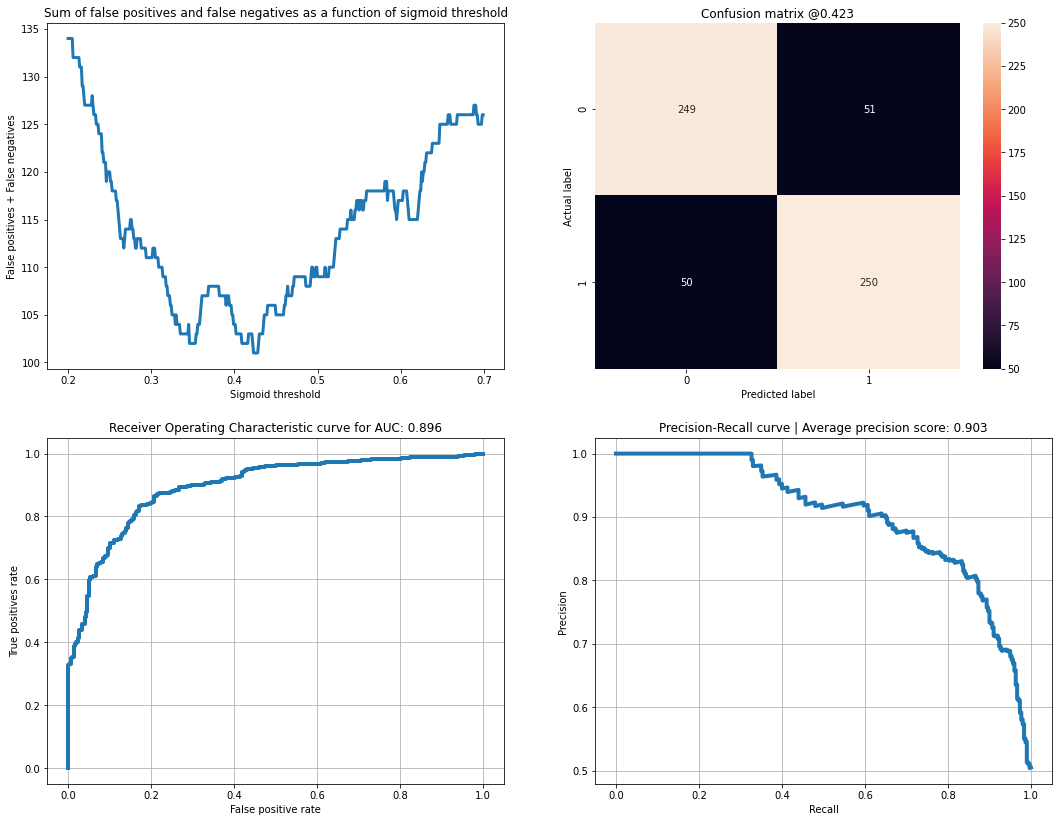

In [36]:
min_threshold = calculate_model_performance_metrics('CNN_Base_8429', test_generator, show_plots=True)

Now let's load some faces to see what are the predictions.

Found 600 images belonging to 2 classes.


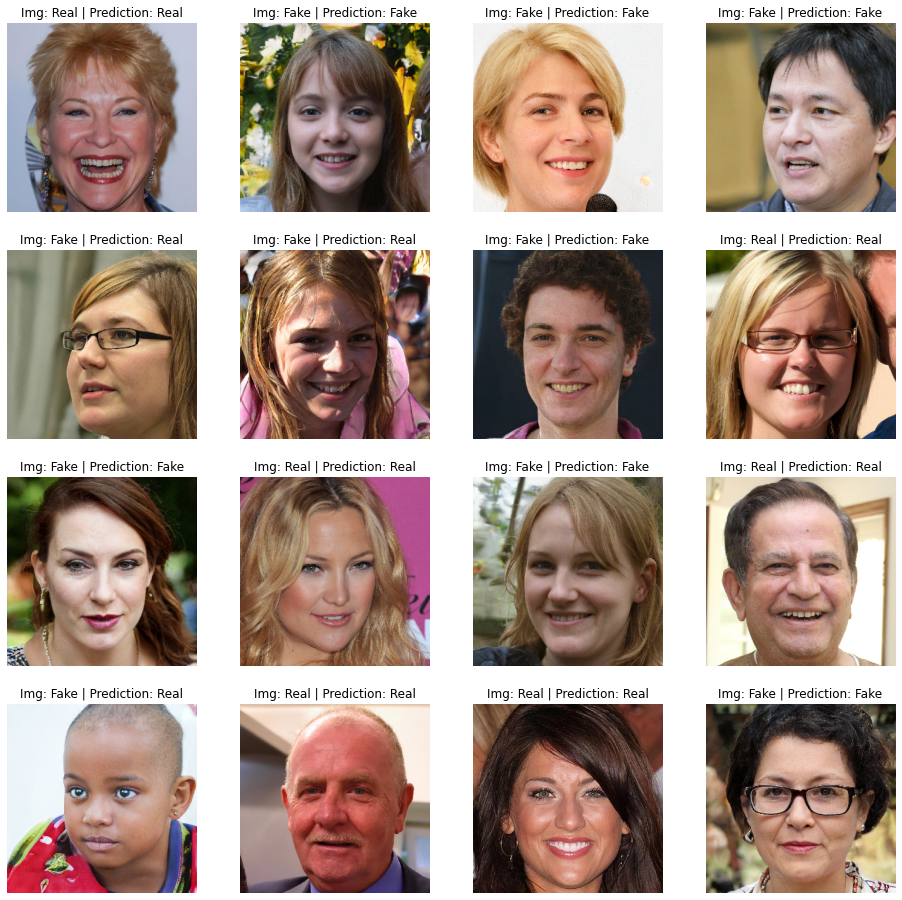

In [47]:
labels = {1.0: 'Real', 0.0: 'Fake'}

test_generator = test_datagen.flow_from_directory(TEST_DIR, target_size=(img_size, img_size), class_mode='binary')
loaded_model = tf.keras.models.load_model('CNN_Base_8429.hdf5')

for images, images_labels in test_generator:
    plt.figure(figsize=(16, 16))
    predictions = tf.where(loaded_model.predict(images) > min_threshold, 1, 0)
    predictions = tf.reshape(predictions, [-1]).numpy()

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.title(f'Img: {labels[images_labels[i]]} | Prediction: {labels[predictions[i]]}')
        plt.imshow(np.uint8(255 * images[i]))
        plt.axis('off')
    break

By manipulating the sigmoid threshold an accuracy of **83.2**% was achieved. Let's try to increase the score and explore some other approaches. Let's give transfer learning a try. For this purpose, a previously trained network on a different dataset is going to be used here. The network used is the [VGG-Face CNN descriptor](https://github.com/rcmalli/keras-vggface). The VGG-Face CNN descriptors are computed using a CNN implementation based on the VGG-Very-Deep-16 CNN architecture and are evaluated on the Labeled Faces in the Wild and the YouTube Faces datasets. Since we're only going to load the feature extraction layers, the model will be initialized as <code>VGGFace(include_top=False)</code> and the layers will be set to not be trained when the model is compiled. Afterwards, the results are flattened and fed through two dense layers, one of which is the output layer activated by a sigmoid function like we saw previously. Like in the previous example, there is the need to split the training set to get a validation set (20%). The <code>image_size</code> is set to 224 by 224 pixels, since this is the standard size used by the VGGFace model. This time we won't do any image augmentation, just reading the images directly and resizing them. The <code>batch_size</code> is kept at 32 just like the previous model.

In [38]:
vgg_img_size = 224
vgg_batch_size = 32

vgg_train_dataset = image_dataset_from_directory(
    TRAINING_DIR,
    batch_size=vgg_batch_size,
    image_size=(vgg_img_size, vgg_img_size),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

vgg_validation_dataset = image_dataset_from_directory(
    TRAINING_DIR,
    batch_size=vgg_batch_size,
    image_size=(vgg_img_size, vgg_img_size),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

vgg_test_set = image_dataset_from_directory(
    TEST_DIR,
    batch_size=vgg_batch_size,
    image_size=(vgg_img_size, vgg_img_size),
    shuffle=False
)

Found 1400 files belonging to 2 classes.
Using 1120 files for training.
Found 1400 files belonging to 2 classes.
Using 280 files for validation.
Found 600 files belonging to 2 classes.


In [48]:
vgg_model = VGGFace(include_top=False, model='vgg16', input_shape=(vgg_img_size, vgg_img_size, 3))

for layer in vgg_model.layers:
    layer.trainable = False

last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(512, activation='relu', name='fc6')(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid', name='fc8')(x)
custom_vgg_model = Model(vgg_model.input, out)
custom_vgg_model.summary()

custom_vgg_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

callback = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='model.hdf5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
]

history = custom_vgg_model.fit(
    vgg_train_dataset,
    epochs=20,
    validation_data=vgg_validation_dataset,
    verbose=1,
    callbacks=callback
)

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)     

Let's check how well the model did.

In [39]:
load_and_test_model('VGG16_8714', vgg_test_set)

19/19 [==============================] - 20s 1s/step - loss: 0.6070 - accuracy: 0.8567
Test loss: 0.61, Test accuracy: 85.67


85.7%, an increase of 2.5%! Not too bad. Let's get the rest of the performance metrics.

Found 600 files belonging to 2 classes.
Calculating performance metrics for model vgg16_test_8567_l_6102_val_8714
19/19 [==============================] - 2s 111ms/step
Minimizer of false positives and false negatives: 0.276
Binary Accuracy: 0.857
Precision: 0.834
Recall: 0.890
True Positives: 267.000
True Negatives: 247.000
False Positives: 53.000
False Negatives: 33.000
Number of right guesses: 514.000
Number of wrong guesses: 86.000
Area under curve ROC: 0.925
F1-Score: 0.861


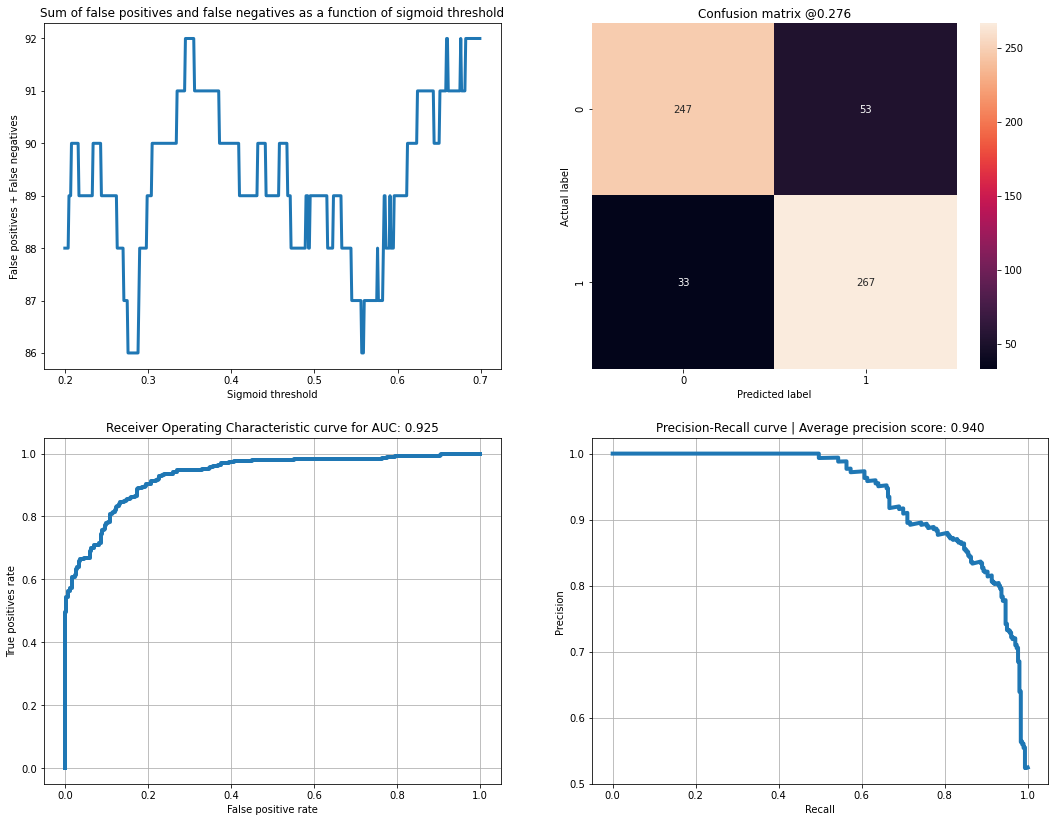

In [40]:
test_vgg_test_full_batch = image_dataset_from_directory(TEST_DIR, batch_size=600,
                                                        image_size=(vgg_img_size, vgg_img_size), shuffle=False)

vgg_metrics = calculate_model_performance_metrics('VGG16_8714', test_vgg_test_full_batch, transfer_ml=True,
                                                  model_version=1, show_plots=True)

Quite a significant increase in the recall! 83.3% to 89%! 15 more faces were predicted correctly and, thus the AUC also increased to 92.5% (from 89.6%). The increase in the recall is also mirrored in the F1-score: 86.1%, an increase of 2.9%.

Lastly in this notebook, we'll try to increase the score even further by running one last model using cropped faces and the <code>senet50</code> model from <code>VGGFace</code>. To crop the faces the Multi-Task Cascaded Convolutional Networks - MTCNN - framework was used. To start things off, the paths of our new training and test sets are created to get a place to store the cropped faces without having to change the original dataset.

In [3]:
CROPPED_DIRS = ['cropped_train_dataset', 'cropped_test_dataset']
FACE_TYPE = ['fake', 'real']

cropped_paths = [Path.joinpath(Path.cwd(), dir, face).mkdir(parents=True, exist_ok=True) for dir in CROPPED_DIRS for face in FACE_TYPE]

Let's initialize the detector to run the cropper function on each face from the dataset.

In [4]:
# Initialize the face detector
detector = MTCNN()


def img_cropper(path, subs, files):
    pixels = plt.imread(path + subs + '/' + files)
    faces = detector.detect_faces(pixels)
    x1, y1, width, height = faces[0]['box']
    x2, y2 = x1 + width, y1 + height
    coordinates = (x1, y1, x2, y2)
    return pixels, coordinates
    

def run_cropper(path, save_crop):
    for subs in os.listdir(path):
        for files in tqdm(os.listdir(path + subs)):
            try:
                if 'fake' in path + subs + files and 'jpg' in path + subs + files:
                    pixels, coordinates = img_cropper(path, subs, files)
                    Image.fromarray(pixels).crop(coordinates).save(
                        Path.joinpath(Path.cwd(), save_crop, 'fake', files))

                elif 'real' in path + subs + files and 'jpg' in path + subs + files:
                    pixels, coordinates = img_cropper(path, subs, files)
                    Image.fromarray(pixels).crop(coordinates).save(
                        Path.joinpath(Path.cwd(), save_crop, 'real', files))

            except (IndexError or SystemError):
                print('The many face god does not approve (GOT)')

In [52]:
run_cropper(str(TRAINING_DIR).__add__('/'), CROPPED_DIRS[0])
run_cropper(str(TEST_DIR).__add__('/'), CROPPED_DIRS[1])

100%|██████████| 300/300 [03:29<00:00,  1.43it/s]


Performing the mapping of the paths to where the cropped images are stored.

In [41]:
CROPPED_TRAINING_DIR = Path.joinpath(Path.cwd(), CROPPED_DIRS[0])
CROPPED_TEST_DIR = Path.joinpath(Path.cwd(), CROPPED_DIRS[1])

print(f'Total cropped training images REAL: {len(os.listdir(Path.joinpath(CROPPED_TRAINING_DIR, "real")))}')
print(f'Total cropped training images FAKE: {len(os.listdir(Path.joinpath(CROPPED_TRAINING_DIR, "fake")))}\n')

print(f'Total cropped test images REAL: {len(os.listdir(Path.joinpath(CROPPED_TEST_DIR, "real")))}')
print(f'Total cropped test images FAKE: {len(os.listdir(Path.joinpath(CROPPED_TEST_DIR, "fake")))}')

Total cropped training images REAL: 700
Total cropped training images FAKE: 700

Total cropped test images REAL: 300
Total cropped test images FAKE: 300


Looks like everything worked well and we got our 2000 faces - 1400 training set plus 600 test set. Let's see if the faces were cropped as expected.

In [42]:
snet_batch_size = 32
snet_img_size = 224
seed = 42

snet_training_set = image_dataset_from_directory(
    CROPPED_TRAINING_DIR,
    batch_size=snet_batch_size,
    image_size=(snet_img_size, snet_img_size),
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset='training'
)

snet_validation_set = image_dataset_from_directory(
    CROPPED_TRAINING_DIR,
    batch_size=snet_batch_size,
    image_size=(snet_img_size, snet_img_size),
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset='validation'
)

snet_test_set = image_dataset_from_directory(
    CROPPED_TEST_DIR,
    batch_size=snet_batch_size,
    image_size=(snet_img_size, snet_img_size)
)

Found 1400 files belonging to 2 classes.
Using 1120 files for training.
Found 1400 files belonging to 2 classes.
Using 280 files for validation.
Found 600 files belonging to 2 classes.


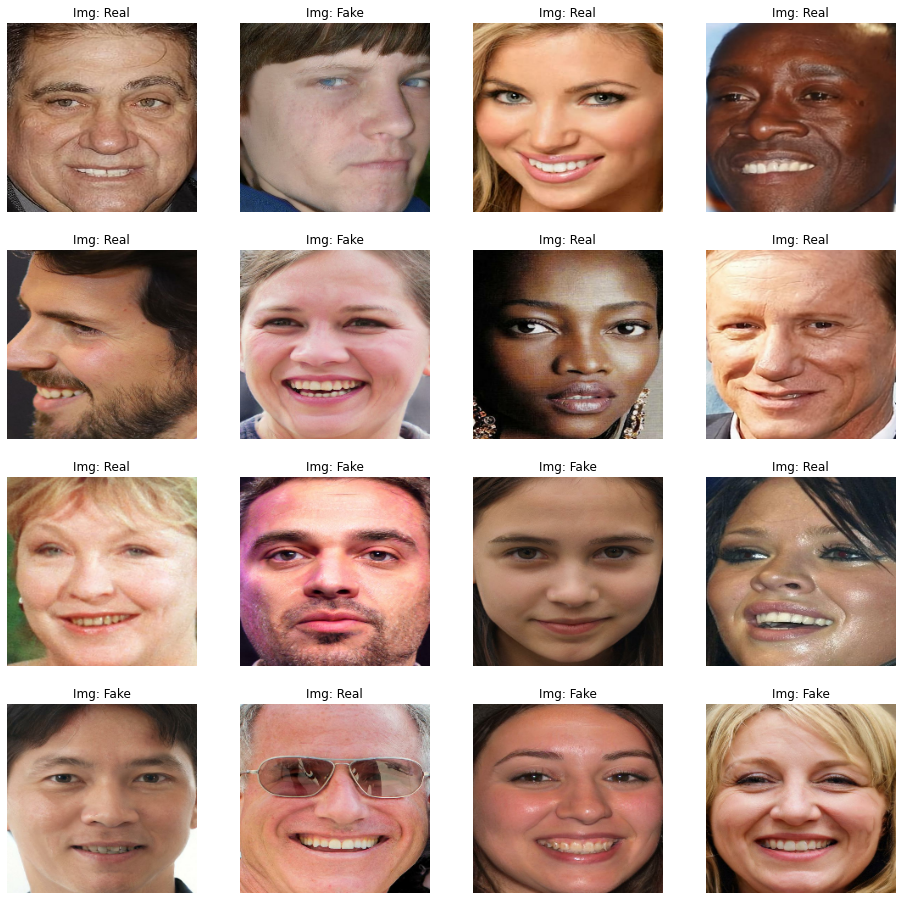

In [43]:
labels = {1.0: 'Real', 0.0: 'Fake'}

plt.figure(figsize=(16, 16))
for images, images_labels in snet_training_set.take(1):   
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        label = tf.reshape(images_labels[i], [-1]).numpy()
        plt.title(f'Img: {labels[label[0]]}')
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')

Great! Everything worked out as expected. Time to define, compile and fit our model.

In [18]:
snet_model = VGGFace(include_top=False, input_shape=(snet_img_size, snet_img_size, 3), model='senet50')

for layer in snet_model.layers:
    layer.trainable = False

last_layer = snet_model.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid', name='classifier')(x)
custom_snet_model = Model(snet_model.input, out)

custom_snet_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

callback = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='model.hdf5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
]

history = custom_snet_model.fit(
    snet_training_set,
    epochs=10,
    validation_data=snet_validation_set,
    verbose=1,
    callbacks=callback
)

104947712/104944616 [==============================] - 8s 0us/step
Epoch 1/10
35/35 [==============================] - ETA: 0s - loss: 1.9700 - accuracy: 0.7750
Epoch 00001: val_loss improved from inf to 0.99313, saving model to model.hdf5
35/35 [==============================] - 191s 5s/step - loss: 1.9700 - accuracy: 0.7750 - val_loss: 0.9931 - val_accuracy: 0.8214
Epoch 2/10
35/35 [==============================] - ETA: 0s - loss: 0.7752 - accuracy: 0.8571
Epoch 00002: val_loss improved from 0.99313 to 0.65399, saving model to model.hdf5
35/35 [==============================] - 188s 5s/step - loss: 0.7752 - accuracy: 0.8571 - val_loss: 0.6540 - val_accuracy: 0.8714
Epoch 3/10
35/35 [==============================] - ETA: 0s - loss: 0.3123 - accuracy: 0.9089
Epoch 00003: val_loss improved from 0.65399 to 0.63042, saving model to model.hdf5
35/35 [==============================] - 188s 5s/step - loss: 0.3123 - accuracy: 0.9089 - val_loss: 0.6304 - val_accuracy: 0.8393
Epoch 4/10
35/35

Let's load and test the model now.

In [44]:
load_and_test_model('SENET50_8929', snet_test_set)

19/19 [==============================] - 3s 133ms/step - loss: 0.4074 - accuracy: 0.8750
Test loss: 0.41, Test accuracy: 87.5


Almost 88%! An increase around 2% from the last model and almost 6% increase from the first one. Like previously, let's get the rest of the performance values.

Found 600 files belonging to 2 classes.
Calculating performance metrics for model senet50_loss_0804_val_8929
19/19 [==============================] - 2s 94ms/step
Minimizer of false positives and false negatives: 0.670
Binary Accuracy: 0.902
Precision: 0.908
Recall: 0.893
True Positives: 268.000
True Negatives: 273.000
False Positives: 27.000
False Negatives: 32.000
Number of right guesses: 541.000
Number of wrong guesses: 59.000
Area under curve ROC: 0.959
F1-Score: 0.901


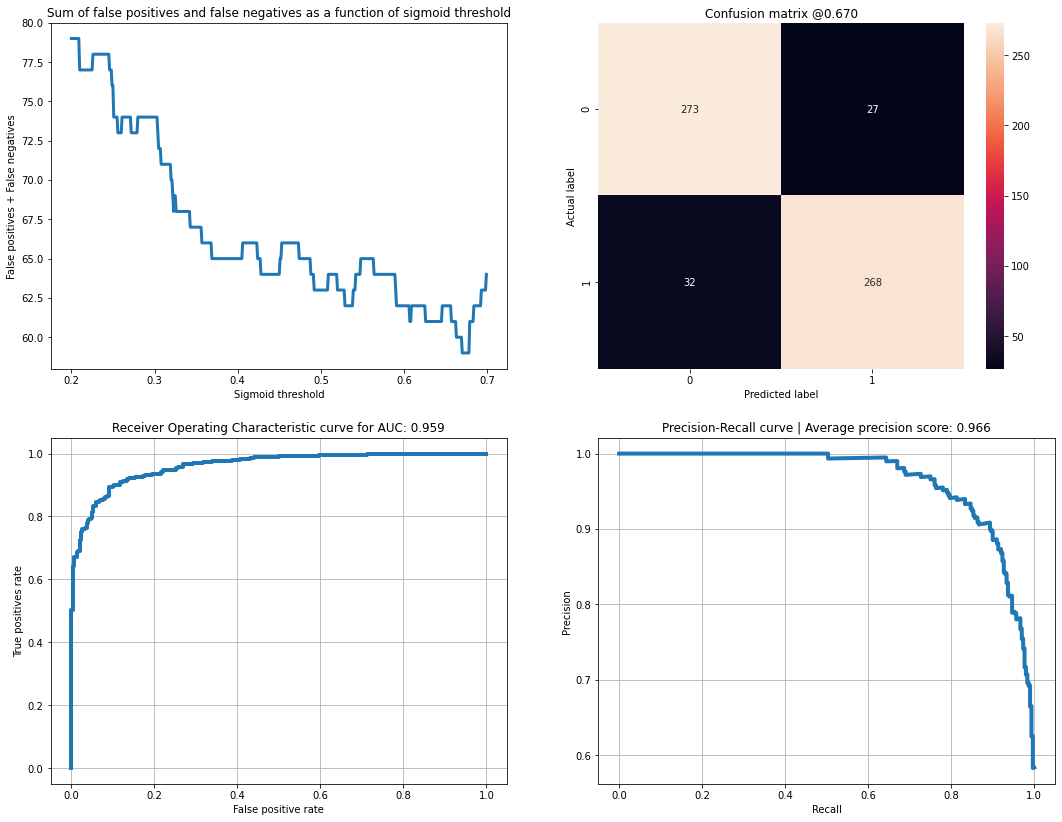

In [45]:
snet_test_full_batch = image_dataset_from_directory(CROPPED_TEST_DIR, batch_size=600,
                                                    image_size=(snet_img_size, snet_img_size), shuffle=False)

snet_metrics = calculate_model_performance_metrics('SENET50_8929', snet_test_full_batch, transfer_ml=True,
                                                   model_version=2, show_plots=True)

90.2% (+4.5%) of binary accuracy, 90.8% (+7.4%) of precision, 89.3% (+0.3%) of recall. Massive increase in the accuracy and precision! This results in less 27 faces with a wrong prediction compared to the previous model. Indeed, this is also observed in the AUC and F1-score, which increased to 95.9% and 90.1% respectively. Removing the background from each photo allowed the model to focus only on the facial features, although this can be a double-edge sword due to how the stitching is made or which model is used. Some stitching artifacts can be found in the fake photos around the ears, chin and hair areas, which can be the main features that the model can use to predict fake from real faces. Nevertheless, the model proved quite successful with an accuracy above 90%.

**Final Remarks**

The main challenges faced during model development were related to overfitting the training data, mainly in the <code>CNN_base</code> model. As stated previously, several approaches were taken to fix this issue, for instance, changing the model's architecture, adding regularization and more image augmentation options. These proved to be unsuccessful due to scarcity of data. For that reason, the model would quickly pick-up features from the training data, therefore, ending with a poor generalization. The author's opinion is that increasing the amount of training data would allow the model to generalize better by learning more features. This would be the main factor to counteract overfitting. A common approach to deal with a small training dataset is to use a previous trained model for feature extraction, otherwise known as transfer learning, which was what was used here. The <code>VGGFace</code> model was trained on a similar domain to what is being used here, the only difference being that the datasets have massive amounts of faces to learn features from. We took advantage of this by instantiating the pre-trained model and then adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier are updated during training. Thus, the convolutional layer extracts all the features associated with each image and then the classifier is only trained to determine the class to which the image belongs to (from the original dataset).